In [1]:
import numpy as np
import pandas as pd
import preprocessing as pp
import tensorflow as tf
import preprocessing as pp
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
np.random.seed(1313)
tf.random.set_seed(131313)

In [5]:
X = np.load("data/numpy/X_with_danger_and_zones.npy")
y_true = np.load("data/numpy/y_with_danger_and_zones.npy")

In [4]:
plays = pd.read_csv('data/csv/game_plays.csv')
games = pd.read_csv('data/csv/game.csv')

In [6]:
# games = games[np.abs(games['home_goals']-games['away_goals']) >= 4]
# plays = plays[plays['game_id'].isin(games['game_id'].unique())]

In [4]:
events = ['Shot', 'Missed Shot']

In [8]:
y_binary = pp.load_data(plays, games, include=['danger', 'zones'], return_arrays=True, binary_y=True, suffix='_with_danger_and_zones')[1]

In [9]:
print(X.shape)
print(y_true.shape)
print(y_binary.shape)

(11244, 366, 16)
(11244, 3)
(11244, 2)


In [13]:
X_train, X_test, y_train, y_test, y_true_train, y_true_test = train_test_split(X, y_binary, y_true, test_size=0.25)

In [8]:
# data = {'Goals': tuple(X[:,:,-1]), 'Result': y[:,0]}
# df = pd.DataFrame(data, columns=['Goals', 'Result'])
# pd.crosstab(df['Goals'].astype(str), df['Result'])

In [14]:
print(np.isnan(X).any())

False


In [15]:
data_shape = tuple(X.shape[1:])
print(data_shape)

(366, 16)


In [26]:
def confusion_matrix(y_test, y_pred, classes=['home win', 'OT/SO', 'away win'], normalize=True, cmap=plt.cm.coolwarm, title=None):
    con_mat = tf.math.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)).numpy()
    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    con_mat_df = pd.DataFrame(con_mat_norm, index=classes, columns=classes)
    
    ax = sns.heatmap(con_mat_df, annot=True, square=True, cmap=cmap)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    return ax

In [16]:
print(np.sum(y_train, axis=0))
print(np.sum(y_test, axis=0))

[4606 3827]
[1531 1280]


In [20]:
model_mlp = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu', input_shape=data_shape)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(32, activation='relu')),
    # tf.keras.layers.Dense(16, activation='relu'),
    # tf.keras.layers.Dense(8, activation='relu'),
    # tf.keras.layers.AveragePooling1D(16),
    # tf.keras.layers.Conv1D(64, 8, activation='relu'),
    # tf.keras.layers.Conv1D(32, 8, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

In [21]:
# optimizer = tf.keras.optimizers.RMSprop(lr=0.001)

model_mlp.compile(optimizer='RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model_mlp.fit(X_train, y_train, epochs=10, validation_split=0.25)
model_mlp.evaluate(X_test, y_test, verbose=0)

Train on 6324 samples, validate on 2109 samples
Epoch 1/10
6324/6324 [==============================] - 12s 2ms/sample - loss: 0.6386 - accuracy: 0.6336 - val_loss: 0.6082 - val_accuracy: 0.6780
Epoch 2/10
6324/6324 [==============================] - 7s 1ms/sample - loss: 0.5668 - accuracy: 0.7086 - val_loss: 0.6341 - val_accuracy: 0.6615
Epoch 3/10
6324/6324 [==============================] - 7s 1ms/sample - loss: 0.5345 - accuracy: 0.7348 - val_loss: 0.6404 - val_accuracy: 0.6572
Epoch 4/10
6324/6324 [==============================] - 8s 1ms/sample - loss: 0.5155 - accuracy: 0.7502 - val_loss: 0.6080 - val_accuracy: 0.6908
Epoch 5/10
6324/6324 [==============================] - 7s 1ms/sample - loss: 0.4870 - accuracy: 0.7753 - val_loss: 0.6012 - val_accuracy: 0.6918
Epoch 6/10
6324/6324 [==============================] - 8s 1ms/sample - loss: 0.4706 - accuracy: 0.7800 - val_loss: 0.6268 - val_accuracy: 0.6719
Epoch 7/10
6324/6324 [==============================] - 8s 1ms/sample - los

[0.6012510857901001, 0.70757735]

In [23]:
y_pred_mlp = model_mlp.predict(X_test)

In [24]:
print(np.sum(np.equal(y_pred_mlp.argmax(axis=1), 0)))
print(np.sum(np.equal(y_pred_mlp.argmax(axis=1), 1)))
print(np.sum(np.equal(y_pred_mlp.argmax(axis=1), 2)))

1351
1460
0


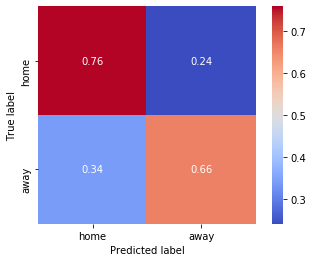

In [27]:
confusion_matrix(y_pred_mlp, y_test, classes=['home', 'away'])

plt.show()

In [28]:
y_pred_mlp

array([[0.42588872, 0.5741113 ],
       [0.83026624, 0.1697338 ],
       [0.8564282 , 0.1435718 ],
       ...,
       [0.19546854, 0.80453146],
       [0.5897092 , 0.41029075],
       [0.04172759, 0.95827234]], dtype=float32)

In [36]:
len(y_pred_mlp[y_pred_mlp.max(axis=1) <= 0.6])

464

In [29]:
y_true_pred_mlp = np.zeros((y_pred_mlp.shape[0], 3))

In [ ]:
for i in range(len(y_true_pred_mlp)):
    

In [104]:
print(classification_report(y_test.argmax(axis=1), y_pred_mlp.argmax(axis=1), target_names=['home win', 'OT/SO', 'away win']))

              precision    recall  f1-score   support

    home win       0.64      0.76      0.69      1225
       OT/SO       0.30      0.13      0.19       646
    away win       0.59      0.67      0.63       940

    accuracy                           0.59      2811
   macro avg       0.51      0.52      0.50      2811
weighted avg       0.55      0.59      0.56      2811



In [38]:
model_conv1d = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(64, 12, activation='relu', input_shape=data_shape),
    tf.keras.layers.Conv1D(64, 8, activation='relu'),
    tf.keras.layers.AveragePooling1D(4),
    tf.keras.layers.Conv1D(32, 6, activation='relu'),
    tf.keras.layers.Conv1D(32, 6, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])
model_conv1d.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [39]:
model_conv1d.fit(X_train, y_train, epochs=10, validation_split=0.2)
model_conv1d.evaluate(X_test, y_test, verbose=2)

Train on 6746 samples, validate on 1687 samples
Epoch 1/10
6746/6746 [==============================] - 20s 3ms/sample - loss: 0.6522 - accuracy: 0.6161 - val_loss: 0.6174 - val_accuracy: 0.6716
Epoch 2/10
6746/6746 [==============================] - 19s 3ms/sample - loss: 0.5577 - accuracy: 0.7281 - val_loss: 0.5533 - val_accuracy: 0.7184
Epoch 3/10
6746/6746 [==============================] - 19s 3ms/sample - loss: 0.5383 - accuracy: 0.7341 - val_loss: 0.5454 - val_accuracy: 0.7202
Epoch 4/10
6746/6746 [==============================] - 20s 3ms/sample - loss: 0.5344 - accuracy: 0.7412 - val_loss: 0.5861 - val_accuracy: 0.6935
Epoch 5/10
6746/6746 [==============================] - 24s 4ms/sample - loss: 0.5262 - accuracy: 0.7470 - val_loss: 0.5429 - val_accuracy: 0.7309
Epoch 6/10
6746/6746 [==============================] - 23s 3ms/sample - loss: 0.5207 - accuracy: 0.7529 - val_loss: 0.5366 - val_accuracy: 0.7214
Epoch 7/10
6746/6746 [==============================] - 21s 3ms/sample

[0.5592842087419972, 0.7143365]

In [40]:
y_pred_conv1d = model_conv1d.predict(X_test)

In [41]:
print(np.sum(np.equal(y_pred_conv1d.argmax(axis=1), 0)))
print(np.sum(np.equal(y_pred_conv1d.argmax(axis=1), 1)))
print(np.sum(np.equal(y_pred_conv1d.argmax(axis=1), 2)))

2098
713
0


In [42]:
print(np.mean(y_pred_conv1d[y_pred_conv1d.argmax(axis=1) == 0][:, 0]))
print(np.mean(y_pred_conv1d[y_pred_conv1d.argmax(axis=1) == 1][:, 1]))
print(np.mean(y_pred_conv1d[y_pred_conv1d.argmax(axis=1) == 2][:, 2]))

0.78755695
0.68736935


IndexError: index 2 is out of bounds for axis 1 with size 2

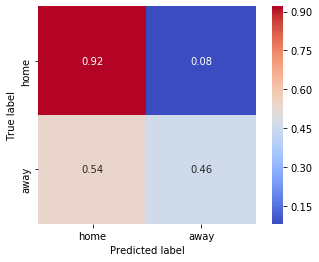

In [43]:
confusion_matrix(y_test, y_pred_conv1d, classes=['home', 'away'])

plt.show()

In [101]:
print(classification_report(y_test.argmax(axis=1), y_pred_conv1d.argmax(axis=1), target_names=['home win', 'OT/SO', 'away win']))

              precision    recall  f1-score   support

    home win       0.65      0.86      0.74      1225
       OT/SO       0.55      0.06      0.11       646
    away win       0.64      0.75      0.69       940

    accuracy                           0.64      2811
   macro avg       0.61      0.56      0.51      2811
weighted avg       0.62      0.64      0.58      2811



In [23]:
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=data_shape),
    # tf.keras.layers.LSTM(32, return_sequences=True),
    # tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(y.shape[1], activation='softmax'),
])
model_lstm.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
model_lstm.fit(X_train, y_train, epochs=10, validation_split=0.25)

Train on 6324 samples, validate on 2109 samples
Epoch 1/10
6324/6324 [==============================] - 53s 8ms/sample - loss: 1.0732 - accuracy: 0.4303 - val_loss: 1.0682 - val_accuracy: 0.4267
Epoch 2/10
6324/6324 [==============================] - 52s 8ms/sample - loss: 1.0715 - accuracy: 0.4307 - val_loss: 1.0680 - val_accuracy: 0.4267
Epoch 3/10
6324/6324 [==============================] - 52s 8ms/sample - loss: 1.0713 - accuracy: 0.4307 - val_loss: 1.0699 - val_accuracy: 0.4267
Epoch 4/10
6324/6324 [==============================] - 52s 8ms/sample - loss: 1.0715 - accuracy: 0.4307 - val_loss: 1.0682 - val_accuracy: 0.4267
Epoch 5/10
6324/6324 [==============================] - 53s 8ms/sample - loss: 1.0714 - accuracy: 0.4307 - val_loss: 1.0684 - val_accuracy: 0.4267
Epoch 6/10
6324/6324 [==============================] - 52s 8ms/sample - loss: 1.0714 - accuracy: 0.4307 - val_loss: 1.0683 - val_accuracy: 0.4267
Epoch 7/10
6324/6324 [==============================] - 53s 8ms/sample

In [ ]:
model_lstm.evaluate(X_test, y_test, verbose=2)

In [ ]:
y_pred_lstm = model_lstm.predict(X_test)

print(np.sum(np.equal(y_pred_lstm.argmax(axis=1), 0)))
print(np.sum(np.equal(y_pred_lstm.argmax(axis=1), 1)))
print(np.sum(np.equal(y_pred_lstm.argmax(axis=1), 2)))

In [60]:
model_rnn = tf.keras.models.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, input_shape=data_shape),
    tf.keras.layers.SimpleRNN(64),
    # tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(3, activation='sigmoid'),
])
model_rnn.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [61]:
model_rnn.fit(X_train, y_train, epochs=10, validation_split=0.25)
model_rnn.evaluate(X_test, y_test, verbose=0)

Train on 6324 samples, validate on 2109 samples
Epoch 1/10
6324/6324 [==============================] - 49s 8ms/sample - loss: 1.0765 - accuracy: 0.4252 - val_loss: 1.0765 - val_accuracy: 0.4301
Epoch 2/10
6324/6324 [==============================] - 46s 7ms/sample - loss: 1.0740 - accuracy: 0.4266 - val_loss: 1.0732 - val_accuracy: 0.4301
Epoch 3/10
6324/6324 [==============================] - 46s 7ms/sample - loss: 1.0739 - accuracy: 0.4266 - val_loss: 1.0728 - val_accuracy: 0.4301
Epoch 4/10
6324/6324 [==============================] - 46s 7ms/sample - loss: 1.0726 - accuracy: 0.4266 - val_loss: 1.0711 - val_accuracy: 0.4301
Epoch 5/10
6324/6324 [==============================] - 55s 9ms/sample - loss: 1.0737 - accuracy: 0.4269 - val_loss: 1.0714 - val_accuracy: 0.4301
Epoch 6/10
6324/6324 [==============================] - 70s 11ms/sample - loss: 1.0718 - accuracy: 0.4266 - val_loss: 1.0713 - val_accuracy: 0.4301
Epoch 7/10
6324/6324 [==============================] - 67s 11ms/samp

[1.0759758330120899, 0.42013517]

In [28]:
y_pred_rnn = model_rnn.predict(X_test)

print(np.sum(np.equal(y_pred_rnn.argmax(axis=1), 0)))
print(np.sum(np.equal(y_pred_rnn.argmax(axis=1), 1)))
print(np.sum(np.equal(y_pred_rnn.argmax(axis=1), 2)))

2811
0
0


In [29]:
model_mixed = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu', input_shape=data_shape)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    # tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax'),
])
model_mixed.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [30]:
model_mixed.fit(X_train, y_train, epochs=10, validation_split=0.25)
model_mixed.evaluate(X_test, y_test, verbose=0)

Train on 6324 samples, validate on 2109 samples
Epoch 1/10
6324/6324 [==============================] - 76s 12ms/sample - loss: 1.0352 - accuracy: 0.4888 - val_loss: 0.9977 - val_accuracy: 0.5349
Epoch 2/10
6324/6324 [==============================] - 68s 11ms/sample - loss: 0.9754 - accuracy: 0.5517 - val_loss: 0.9755 - val_accuracy: 0.5462
Epoch 3/10
6324/6324 [==============================] - 68s 11ms/sample - loss: 0.9385 - accuracy: 0.5732 - val_loss: 0.9426 - val_accuracy: 0.5614
Epoch 4/10
6324/6324 [==============================] - 68s 11ms/sample - loss: 0.9272 - accuracy: 0.5838 - val_loss: 0.9433 - val_accuracy: 0.5837
Epoch 5/10
6324/6324 [==============================] - 67s 11ms/sample - loss: 0.9220 - accuracy: 0.5881 - val_loss: 0.9234 - val_accuracy: 0.5861
Epoch 6/10
6324/6324 [==============================] - 69s 11ms/sample - loss: 0.9182 - accuracy: 0.5859 - val_loss: 0.9424 - val_accuracy: 0.5737
Epoch 7/10
6324/6324 [==============================] - 68s 11ms

[0.9313820695927965, 0.5791533]

In [31]:
y_pred_mixed = model_mixed.predict(X_test)

print(np.sum(np.equal(y_pred_mixed.argmax(axis=1), 0)))
print(np.sum(np.equal(y_pred_mixed.argmax(axis=1), 1)))
print(np.sum(np.equal(y_pred_mixed.argmax(axis=1), 2)))

1656
1
1154
